## Mueller ellipsometry

The notebook reproduces 16 elements of Mueller matrix of 2D gratings (Figure 3) in [Liu et al.,Thin Solid Films,2015](https://www.sciencedirect.com/science/article/abs/pii/S0040609015001224) 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import sys
path_parent=os.path.dirname(os.getcwd())
sys.path.insert(0,path_parent)
from src import Scattering
from src import ReadData 
from src import Computation
from src import Plot
from src import Geo
from src import Tools
from matplotlib.offsetbox import AnchoredText

# Optical index

In [2]:
h=4.135667516*1e-15;#[eV s]      
c=299792458         #[m/s]
path_optical_index=path_parent+'/dataNK/'
path_Si=path_optical_index+ 'c-Si_HJY_Modif.txt'
Si_wl, Si_nk=ReadData.read_nk(path_Si)
Si_wl=h*c/Si_wl*10**9      #eV to nm

In [3]:
wavelength_range=np.linspace(200.,800.,101)
e_Si=ReadData.Interpolate_Optical_Index(wavelength_range,Si_wl, Si_nk)
#reflectance and transmission
u_ref=1; u_trn=1;  e_ref=1; e_trn=np.copy(e_Si);  e_air=1

In [4]:
#HSQ layer:Cauchy model
# The constants have unit of micrometer
A=1.44
B=3.87*10**-3
C=6.93*10**-5

alpha=2.05*10**-4
beta=1.48
wl0=0.4
e_hsq=Tools.Cauchy(wavelength_range/1000,A,B,C,alpha,beta,wl0)

## Input parameters

In [5]:
#Angle
AOI_d = 65
AOI_r=np.radians(AOI_d) 
Azimuth_d=60
Azimuth_r=np.radians(Azimuth_d)

#geometry
Lx_cell=180; Ly_cell=float('inf')  #2D
reso=1
Wx=55 # 2D
Thickness_Sim=[75] # only one layer

# diffraction order in x-y direction
mx=15;my=0    

## Parameters in RCWA

In [6]:
NL=len(Thickness_Sim)
#Geometry
Geo.reso, Geo.Lx_cell, Geo.Ly_cell= reso, Lx_cell, Ly_cell
Geo.mx, Geo.my= mx, my

#Scattering
Scattering.AOI_r, Scattering.Azimuth_r =AOI_r,Azimuth_r

# important
Scattering.Meshgrid()

In [7]:
#layer materials
e_m=[e_hsq] # one layer

Geometry=[]
for lth in range(NL):
    layer_lth={}      
    
    layer_lth['Shape']=Geo.Rectangle2D
    layer_lth['e_base']=1
    layer_lth['e_grt']=e_m[lth]
    layer_lth['Critical']=[Wx]
    layer_lth['Center']=[Lx_cell/2]
   
    Geometry.append(layer_lth)  

## Visualization

In [9]:
geo_e=np.array([Plot.Geo_viz(layer_lth) for layer_lth in Geometry])
Plot.Viz_xy(geo_e,pos_layer=[0])

The current version only support x-y view for 3D structures


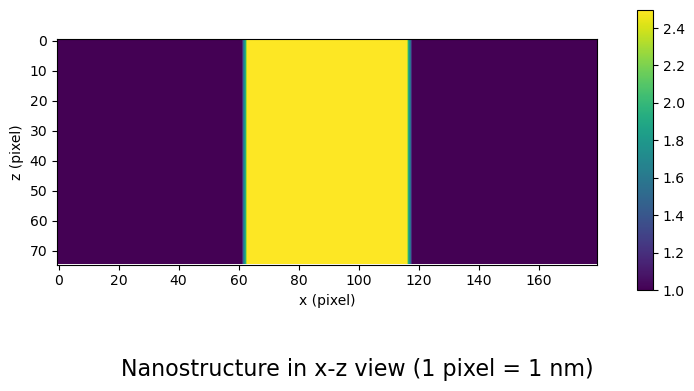

In [10]:
Plot.Viz_z(geo_e,Thickness_Sim)

# Simulation

In [11]:
t0=time.time()
ERC_CONV=[Geo.CONV_layer(wavelength_range,layer_lth) for layer_lth in Geometry]
t_conv=time.time()-t0
print(t_conv)

0.0684964656829834


In [12]:
t0=time.time() 
       
Coeff_XY=[];
for wth in range(len(wavelength_range)):              
                
    Scattering.KxKy_Component(wavelength_range[wth],e_ref,e_trn[wth])    
        
    # S-layer       
    S_layer=[Scattering.S_Layer(Thickness_Sim[lth],ERC_CONV[lth][wth])  for lth in range(NL)] 
    # Combine for S_global
    S_global=Scattering.S_System(S_layer) 
        
    # compute  R to calculate MM        
    S_global_11=S_global[0];    
    order =Scattering.Nharm//2        
         
    rxS,ryS= Scattering.Optical_Response(S_global_11,'pte') 
    rxP,ryP= Scattering.Optical_Response(S_global_11,'ptm')   
    
    Coeff_XY.append([rxP[order,0],ryP[order,0],rxS[order,0],ryS[order,0]])
    
Coeff_XY=np.array(Coeff_XY).transpose(1,0) # shape: 4 x wl 
    
rpp,rps,rsp,rss=Scattering.Rotate_SP(Coeff_XY) #rotate AOI, azimuth
    
# Muller matrix
m11,m12,m13,m14,m22,m23,m24,m33,m34,m44=Computation.Mueller_m(rpp,rps,rsp,rss)  # 9 mm
MM=np.array([-m12/m11,-m13/m11,m14/m11,m22/m11,m23/m11,-m24/m11,m33/m11,-m34/m11,m44/m11])   
MM=Computation.MM9_to_MM16(MM)  # thanks to the symmetry of MM, we can calculate 16 mm from 9 mm
MM=MM.reshape(4,4,len(wavelength_range)) # 4 x 4 x wl       

print(time.time() -t0)    

0.5858421325683594


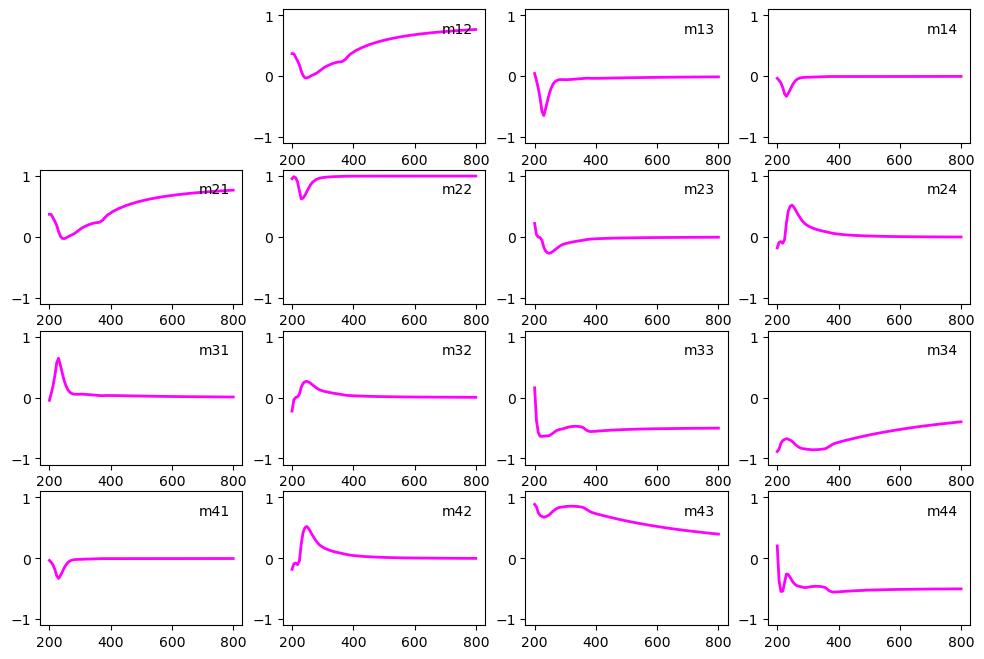

In [13]:
plt.figure(figsize=(12,8))
for i in range(4):
    for j in range(4):
        ax = plt.subplot2grid((4,4), (i,j))  
                    
        ax.plot(wavelength_range,MM[i,j],lw=2,c='magenta')        
        ax.axis(ymin=-1.1,ymax=1.1)  
        #ax.set_xticks([]);       ax.set_yticks([])
        anchored_text = AnchoredText("m" + str(i+1) +str(j+1), loc=1,frameon=False)
        ax.add_artist(anchored_text)
        
ax = plt.subplot2grid((4,4), (0,0))
ax.plot(wavelength_range,MM[0,0],lw=2,c='white')
ax.axis('off')
anchored_text = AnchoredText("", loc=1,frameon=False)
ax.add_artist(anchored_text)
plt.show()

### Note 

The figure is slightly different from the publication because in thenotebook, SWA =90 was used (not trapezoid model)